# Quality control

Here I want to check the data for any weird spikes and 
1. in th EB dataset: for the diving event 2016/2017 cut out the data from 100m and set to 250m and then replace the 100m values with nans
2. cut out weird spike in WB1 dataset 
3. WB datasets: create a 3rd dimension in both datasets
4. concat along a 3rd dimension and use mean of both datasets where 2 values exist

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_name = "data/rtwb1_all_merged.nc"
ds_wb1 = xr.open_dataset(file_name)

In [4]:
file_name = "data/rtwb2_all_merged.nc"
ds_wb2 = xr.open_dataset(file_name)

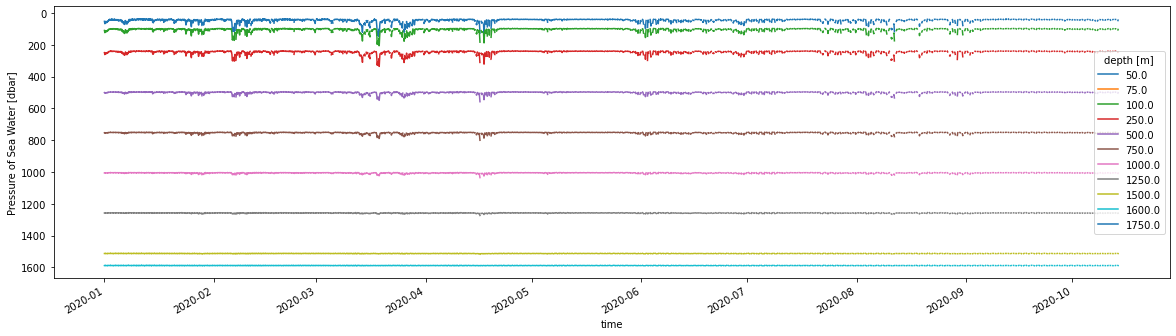

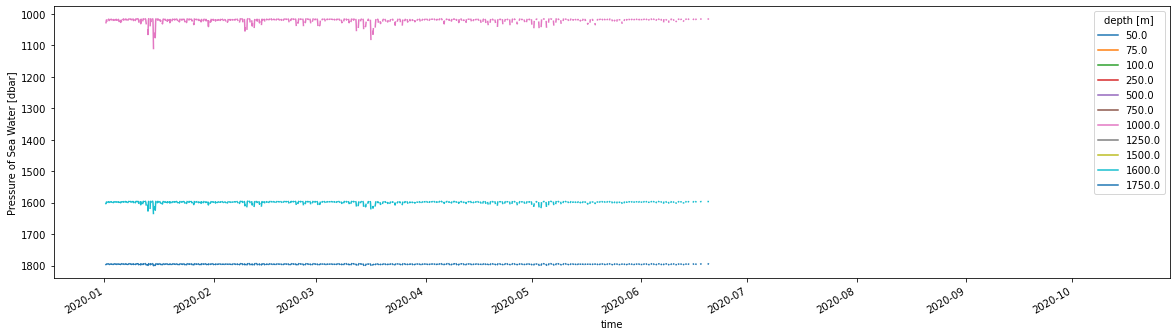

In [5]:
ds_wb1 = ds_wb1.where(ds_wb1.pres>0)
ds_wb1.pres.sel(time='2020').where(ds_wb1.pres>0).plot.line(x='time', figsize = (20,5), yincrease = False); #.where(ds.pres>0);
ds_wb2.pres.sel(time='2020').plot.line(x='time', figsize = (20,5), yincrease = False); #.where(ds.pres>0);
# need to remove the spike

## Combine wb1 and wb2 along a new dimension called moor

In [6]:
ds_wb = xr.concat([ds_wb1, ds_wb2], dim='moor')
display(ds_wb)

<xarray.Dataset>
Dimensions:  (depth: 11, moor: 2, time: 155417)
Coordinates:
  * time     (time) datetime64[ns] 2014-07-17T12:30:01.008000 ... 2020-10-14T...
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.75e+03
Dimensions without coordinates: moor
Data variables:
    temp     (moor, depth, time) float64 nan nan nan nan ... 3.528 nan 3.532 nan
    pres     (moor, depth, time) float64 nan nan nan nan ... nan 1.796e+03 nan
    sal      (moor, depth, time) float64 nan nan nan nan ... 34.94 nan 34.94 nan
Attributes:
    Mooring:          rtwb1
    WaterDepth:       1600
    Start_Date:       2014/07/17
    Start_Time:       12:30
    End_Date:         2015/06/22
    End_Time:         10:30
    Latitude:         57.470666666666666
    Longitude:        -12.705
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

Now we can easily average over the new dimension moor

In [7]:
ds_wb = ds_wb.mean('moor',skipna=True)
display(ds_wb)

<xarray.Dataset>
Dimensions:  (depth: 11, time: 155417)
Coordinates:
  * time     (time) datetime64[ns] 2014-07-17T12:30:01.008000 ... 2020-10-14T...
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.75e+03
Data variables:
    temp     (depth, time) float64 nan nan nan nan nan ... 3.528 nan 3.532 nan
    pres     (depth, time) float64 nan nan nan nan ... nan 1.796e+03 nan
    sal      (depth, time) float64 nan nan nan nan nan ... 34.94 nan 34.94 nan

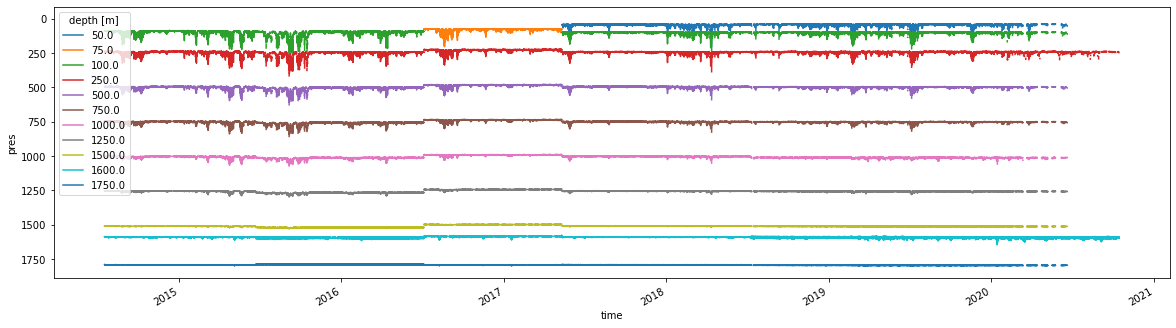

In [8]:
ds_wb.pres.plot.line(x='time', figsize = (20,5), yincrease = False);

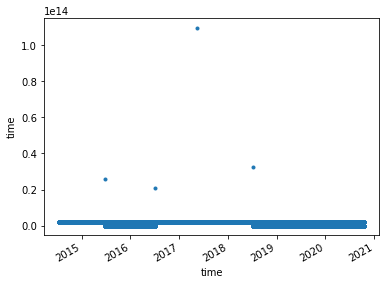

In [16]:
# ds_wb.temp.sel(depth=[1750]).plot.line(x='time', figsize = (20,5), yincrease = False);
# ds_wb2.temp.sel(depth=[1750]).plot.line(x='time', figsize = (20,5), yincrease = False);
ds_wb2.time.diff('time').plot.line('.')

# picking the bits I want to combine into my final dataset

In [10]:
ds_wb = ds_wb.resample(time = "1D").mean(keep_attrs=True);
# ds_wb2 = ds_wb2.resample(time = "1D").mean(keep_attrs=True);

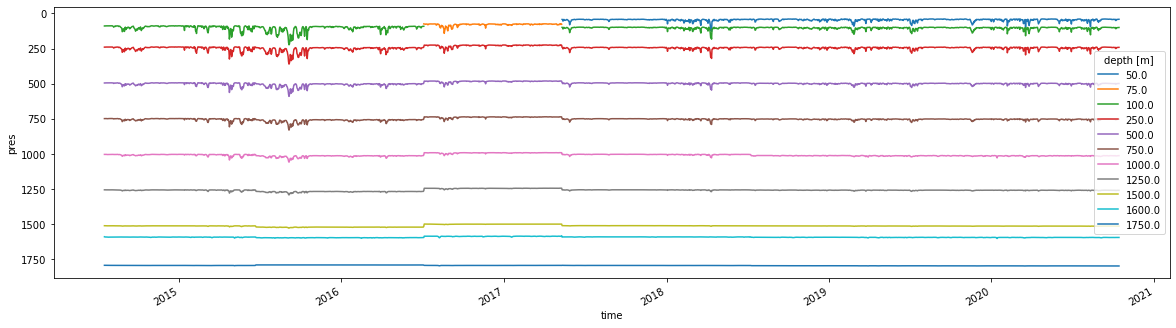

In [11]:
ds_wb.pres.plot.line(x='time', figsize = (20,5),yincrease=False);

In [12]:
ds_wb.to_netcdf('data/rtwb_qc_1D.nc', 
        engine='netcdf4',
        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})

In [13]:
# I cheated a bit and the MHW algorithm does not like it...